<a href="https://colab.research.google.com/github/Jacob-Francis/SWSG_repo/blob/main/Colab_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [30]:
#!apt-get install cuda=10.2.89-1
%matplotlib inline

!pip install pykeops[colab] > install.log
!pip install geomloss[full]
!apt-get install ffmpeg

import torch
import numpy as np
from geomloss import SamplesLoss
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Device configuration
#pytorch.cuda.alloc.conf = expandable_segments
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)
torch.set_default_device(device)

  Preparing metadata (setup.py) ... done
  Created wheel for geomloss: filename=geomloss-0.2.6-py3-none-any.whl size=32246 sha256=d0be18e1334e184e04e272070ce60e08012823358fcb077386053035dea16f31
  Stored in directory: /root/.cache/pip/wheels/0d/c9/80/4387eb03aa215ae557869d6fe8be498fd3d3cf297db2357b67
Successfully built geomloss
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [31]:
def Lloyds(f, N, k=10, Nsteps=3,scali=0.99, epsilon=0.001):

    # Generate initial grid of points for x
    grid_size = int(N**0.5)  # Assuming N is a perfect square
    x = (torch.rand(N, 2,device=device) - 0.5).detach().requires_grad_(True) # Random points in [-1, 1]
    # Generate fine grid of points y with k*N points
    fine_grid_size = int((k * N)**0.5)
    y = torch.stack(torch.meshgrid(torch.linspace(-0.5, 0.5, fine_grid_size,device=device),
                                   torch.linspace(-0.5, 0.5, fine_grid_size,device=device)), dim=-1).reshape(-1, 2)
    y = y[:k * N]

    # Compute weights b proportional to f(y)
    b = f(y)
    b /= b.sum()  # Normalize to make b a probability distribution

    # Uniform weights for points x
    a = torch.full((N,), 1 / N,device=device)

    # Define the entropic OT loss function
    loss_fn = SamplesLoss("sinkhorn", p=2,scaling=scali, blur=epsilon**0.5)

    # Iterative Lloyd's algorithm
    for _ in range(Nsteps):
        # Compute the transport map between x and (y, b)
        loss = loss_fn(a,x,b, y)
        grad = torch.autograd.grad(loss, x)[0]
        x=x.clone().detach().requires_grad_(True)

        # Move points in the direction of the gradient to minimize OT cost
        with torch.no_grad():
            x -= N * grad  # Adjust x by moving in gradient direction

    return x.detach()  # Return points that fit the density function

def init_gaussian(N, k=10, epsilon=0.001,Nsteps=3,scali=0.99,std=[0.2,0.2]):
    def gaussian_density(points, mean=[0, 0], std=[0.1, 0.1]):
        """Evaluates a Gaussian function at given points."""
        dist = torch.distributions.MultivariateNormal(
            torch.tensor(mean,device=device),
            torch.diag(torch.tensor(std,device=device))**2
        )
        return torch.exp(dist.log_prob(points))
    # Run Lloyd's algorithm
    f = lambda y: gaussian_density(y, mean=[0, 0], std=[0.2, 0.2])  # Gaussian density function
    points = Lloyds(f, N, k=k, Nsteps=Nsteps, epsilon=epsilon)
    return points


N = 50
M = 10*N ; N,M = int(N**0.5)**2,int(M**0.5)**2
debiase,scali,epsilon =False,0.99,0.001

#initialisations
grid_size = int(M ** 0.5)
grid = torch.linspace(-.5,.5, grid_size)
y1, y2 = torch.meshgrid(grid, grid, indexing='ij')
Y = torch.stack([y1.flatten(), y2.flatten()], dim=1)[:M]

G=init_gaussian(N,std=[0.3,0.3])


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [34]:
# Parameters
N = 10
N1 = 10  # testing shapes
M = 100
epsilon = 0.01
sigma = 1

# Generate G
# G = np.stack([j.flatten() for j in np.meshgrid(
#     np.linspace(1/(2*N), 1 - 1/(2*N), N, endpoint=True),
#     np.linspace(1/(2*N), 1 - 1/(2*N), N, endpoint=True))], axis=-1)
G = init_gaussian(N*N,std=[0.3,0.3])

# Generate X in the desired format (N * N, 2)
X = np.stack([j.flatten() for j in np.meshgrid(
    np.linspace(1/(2*N1), 1 - 1/(2*N1), N, endpoint=True),
    np.linspace(1/(2*N1), 1 - 1/(2*N1), N, endpoint=True))], axis=-1)

# Generate Y in the desired format (M * M, 2)
Y = np.stack([j.flatten() for j in np.meshgrid(
    np.linspace(1/(2*M), 1 - 1/(2*M), M, endpoint=True),
    np.linspace(1/(2*M), 1 - 1/(2*M), M, endpoint=True))], axis=-1)

In [35]:
G.shape


torch.Size([100, 2])

In [36]:
f1 = np.zeros(N*N)
f2 = np.zeros(N1*N1)
f3 = np.zeros(M*M)

# Compute cost matrices
C_gx = 0.5 * cdist(G, X) ** 2   # Shape (N * N, N * N)
C_xy = 0.5 * cdist(X, Y) ** 2   # Shape (N * N, M * M)

# Expand dimensions to allow broadcasting
C_gx_expanded = C_gx[:, :, np.newaxis]  # Shape (N * N, N * N, 1)
C_xy_expanded = C_xy[np.newaxis, :, :]  # Shape (1, N * N, M * M)

# Stack to form final cost matrix
C = C_gx_expanded + C_xy_expanded

R here is the reference measuer, though everything so far is just uniformly weighted by the number of points

In [37]:
R = 1 / (N**2 * N1**2 * M**2)
f1 = - epsilon * np.log(np.einsum('ijk->i',np.exp((f2[np.newaxis, :, np.newaxis] + f3[np.newaxis, np.newaxis, :] - C) / epsilon)*R))
f2 = - epsilon * np.log(np.einsum('ijk->j',np.exp((f1[:, np.newaxis, np.newaxis] + f3[np.newaxis, np.newaxis, :] - C) / epsilon)*R))
f3 = - epsilon * np.log(np.einsum('ijk->k',np.exp((f2[np.newaxis, :, np.newaxis] + f1[:, np.newaxis, np.newaxis] - C) / epsilon)*R))

# There is a more efficient implementation
X = np.einsum('ijk,ikl->jl', np.exp((f1[:, np.newaxis, np.newaxis] + f2[np.newaxis, :, np.newaxis] + f3[np.newaxis, np.newaxis, :] - C) / epsilon)*R, -G[:,  np.newaxis, :] - Y[np.newaxis,  :, :])

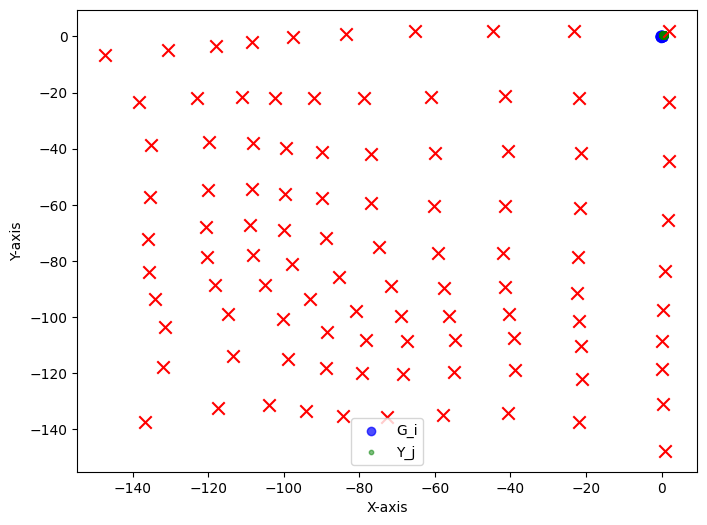

In [41]:
plt.figure(figsize=(8, 6))
plt.scatter(G[:, 0].cpu(), G[:, 1].cpu(), color='blue', label='G_i', alpha=0.7)
plt.scatter(Y[:, 0], Y[:, 1], color='green', s=10, label='Y_j', alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], color='red', marker='x', s=80)
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()